PROVA TRIGGER FASE

In [1]:
import h5py
import numpy as np

In [4]:
noises, signals = [],[]
with h5py.File(r'C:\Users\ricca\Desktop\MAGISTRALE\QTLab2324\DATA ANALYSIS\RUN_10_PULSE_999.hdf5','r') as hdf5:
    I = np.array(hdf5['Signals']['I'])[:int(0.4*1e6)]
    Q = np.array(hdf5['Signals']['Q'])[:int(0.4*1e6)]
    signal = np.unwrap(np.angle(Q+1j*I))

In [5]:
import matplotlib.pyplot as plt

In [6]:
signal -= np.mean(signal[:1000])

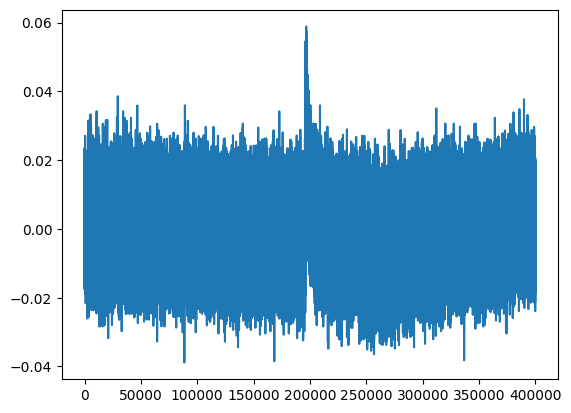

In [7]:
plt.plot(signal)

Vediamo differenti medie mobili

In [8]:
def weighted_moving_average(data, window_size):
    # Converti i dati in un array numpy
    data = np.array(data)
    
    # Crea i pesi come un array numpy
    weights = np.arange(1, window_size + 1)
    
    # Calcola la somma dei pesi
    weight_sum = weights.sum()
    
    # Calcola la media mobile ponderata utilizzando la funzione di convoluzione
    wma = np.convolve(data, weights[::-1], mode='valid') / weight_sum
    
    return wma

In [9]:
def exponential_moving_average(data, window_size):
    # Converti i dati in un array numpy
    data = np.array(data)
    
    # Calcola il coefficiente di ammortamento
    alpha = 2 / (window_size + 1)
    
    # Inizializza un array per l'EMA con lo stesso formato dei dati
    ema = np.zeros_like(data, dtype=float)
    
    # Imposta il primo valore dell'EMA uguale al primo valore dei dati
    ema[0] = data[0]
    
    # Calcola l'EMA usando la formula ricorsiva
    for i in range(1, len(data)):
        ema[i] = alpha * data[i] + (1 - alpha) * ema[i - 1]
    
    return ema

In [10]:
def simple_moving_average(data, window_size):
    # Converti i dati in un array numpy
    data = np.array(data)
    
    # Crea un array di pesi per la finestra (tutti uguali)
    weights = np.ones(window_size) / window_size
    
    # Calcola la SMA usando la funzione di convoluzione
    sma = np.convolve(data, weights, mode='valid')
    
    return sma

In [11]:
wma = weighted_moving_average(signal,180)
ema = exponential_moving_average(signal,180)
sma = simple_moving_average(signal,180)

In [12]:
ema_rms = np.sqrt(np.mean(ema[:2000]**2))

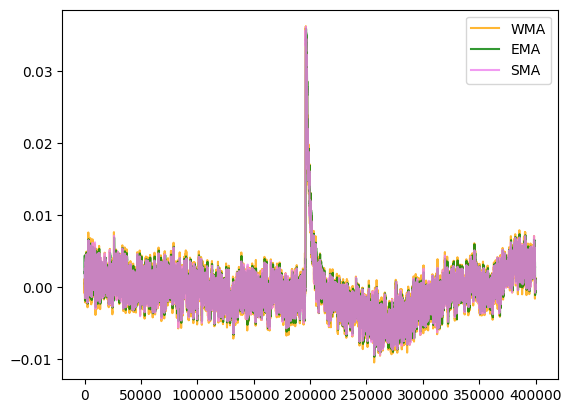

In [13]:
plt.plot(wma, color='orange', label='WMA', alpha=0.8)
plt.plot(ema, color='green', label='EMA', alpha=0.8)
plt.plot(sma, color='violet', label='SMA', alpha=0.8)
plt.legend()

Cosa cambia se vario la dimensione della finestra?

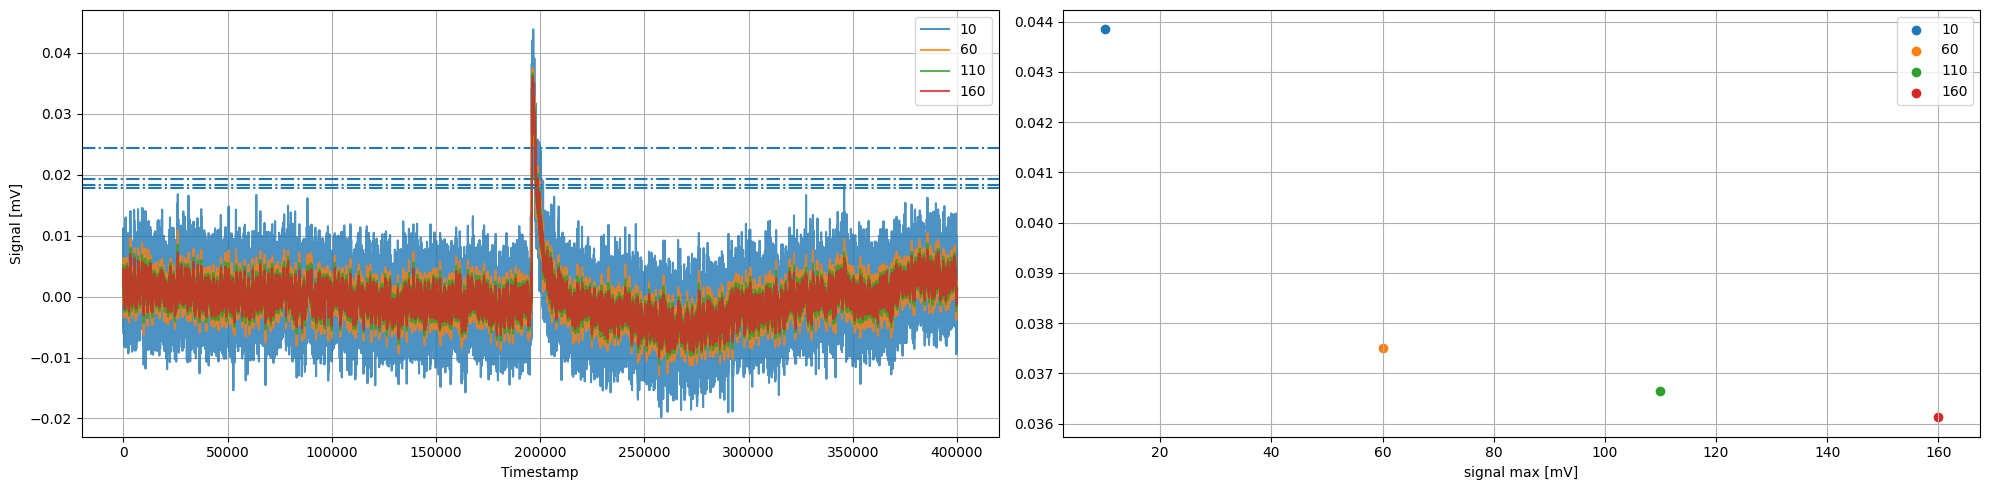

In [19]:
dims = np.arange(10,200,50)
fig, axs = plt.subplots(1,2,figsize=(20,5))
for dim in dims:
    ema = exponential_moving_average(signal,dim)
    axs[0].plot(ema, label=str(dim), alpha=0.8)
    axs[0].axhline(5*np.std(ema),linestyle='-.')
    axs[0].legend()
    axs[1].scatter(dim,max(ema),label=str(dim))
    axs[1].legend()
axs[0].grid()
axs[1].grid()
axs[0].set_xlabel('Timestamp')
axs[0].set_ylabel('Signal [mV]')
axs[1].set_xlabel('Window dimension (points)')
axs[1].set_xlabel('signal max [mV]')
fig.tight_layout()

Mi mangio un pochino il picco, ma sticazzi, ho ammazzato tutto il noise

In [20]:
from scipy.signal import savgol_filter

Calcolo derivata prima e seconda

In [21]:
signal_derivative = savgol_filter(ema,181,8,1)
second = savgol_filter(ema,181,8,2)

Quando calcolo derivate per trigger dovrò togliere il primo e l'ultimo punto della derivata

In [22]:
from scipy.signal import find_peaks

In [23]:
signal_derivative_xp, signal_derivative_props = find_peaks(signal_derivative[1:-1],0)

(-7.452757624220358e-06, 1.2536961384580584e-05)

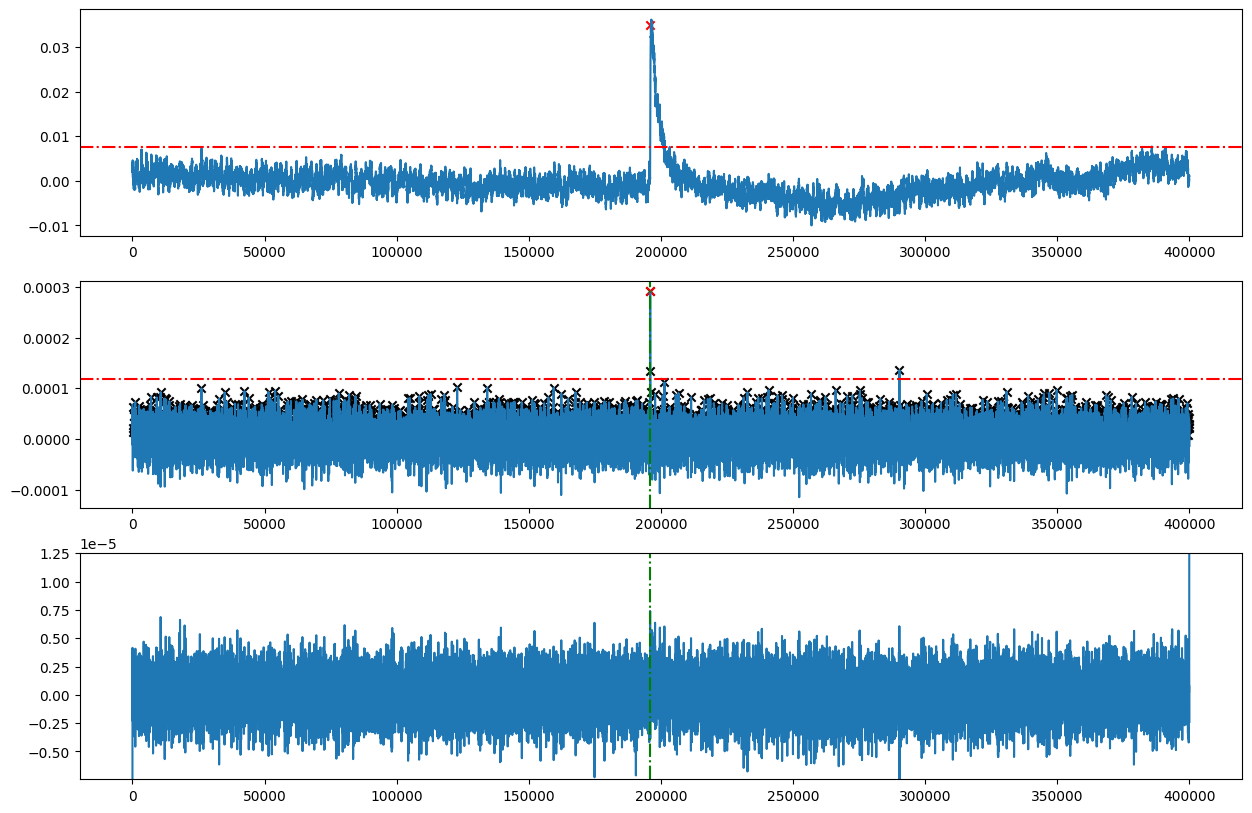

In [24]:
fig,axs = plt.subplots(3,1, figsize=(15,10))
axs[0].plot(ema,label='Signal')
axs[0].axhline(5*np.std(ema[:1000]),linestyle='-.',color='red')
axs[0].scatter(signal_derivative_xp[np.argmax(signal_derivative_props['peak_heights'])],signal[signal_derivative_xp[np.argmax(signal_derivative_props['peak_heights'])]],marker='x',color='red')
axs[1].plot(signal_derivative,label='signal_derivative DErivative')
axs[1].scatter(signal_derivative_xp,signal_derivative_props['peak_heights'],marker='x',color='black')
axs[1].scatter(signal_derivative_xp[np.argmax(signal_derivative_props['peak_heights'])],max(signal_derivative_props['peak_heights']),marker='x',color='red')
axs[2].plot(second,label='Second derivative')
axs[1].axhline(5*np.std(signal_derivative[:1000]),linestyle='-.',color='red')
axs[1].axvline(signal_derivative_xp[np.argmax(signal_derivative_props['peak_heights'])],0,1, linestyle='-.',color='green')
axs[2].scatter(signal_derivative_xp[np.argmax(signal_derivative_props['peak_heights'])],second[signal_derivative_xp[np.argmax(signal_derivative_props['peak_heights'])]],marker='x',color='red')
axs[2].axvline(signal_derivative_xp[np.argmax(signal_derivative_props['peak_heights'])],0,1, linestyle='-.',color='green')
axs[2].set_ylim([min(second[10:-10]),max(second)])
#axs[0].set_xlim([signal_derivative_xp[np.argmax(signal_derivative_props['peak_heights'])]-500,signal_derivative_xp[np.argmax(signal_derivative_props['peak_heights'])]+500])
#axs[1].set_xlim([signal_derivative_xp[np.argmax(signal_derivative_props['peak_heights'])]-500,signal_derivative_xp[np.argmax(signal_derivative_props['peak_heights'])]+500])



Giustamente il massimo della funzione è un punto a tangente orizzontale per la derivata prima, con derivata seconda nulla\
Proviamo a triggerare su entrambe\
L'idea potrebbe essere quella di \
    1 -  Trovo il massimo del segnale filtrato e la sua posizione e verifico sia a 5 sigma dalla base\
    2 -  Trovo il massimo tra i massimi della derivata prima e la sua posizione e verifico sia a 5 sigma dalla base\
    3 -  Verifico che le posizioni del massimo trovate siano simili (range 500 punti)\
    4 -  Prendo 30 punti a sinistra e 30 punti a destra della derivata prima e fitto con parabola


Ora vediamo di allineare il segnale\
Ora che ho calcolato la derivata prima, posso andare a ritroso a partire dal punto di massimo e vedere quando torna a zero stabilmente

In [26]:
def align(signal_derivative,plot=False):

    idxs, props = find_peaks(signal_derivative[1:-1],0)

    try:
        max(props['peak_heights']) > 5 * np.std(signal_derivative)
    except Exception as e:
        print(f"Could not find maximum of derivative -> {e}")

    bw = 0
    mean = max(signal_derivative)

    while(mean > np.std(signal_derivative[:1000]) or mean < -1*np.std(signal_derivative[:1000])):
        bw += 1
        dacalcolare = (signal_derivative[idxs[np.argmax(props['peak_heights'])]-bw:idxs[np.argmax(props['peak_heights'])]])
        mean = np.mean(dacalcolare)

    xmin = idxs[np.argmax(props['peak_heights'])]-bw
    x_alignment = xmin + np.argmin(signal_derivative[xmin:idxs[np.argmax(props['peak_heights'])]])

    if plot:
        fig,axs = plt.subplots(2,1, figsize=(15,10))
        axs[0].plot(signal_derivative,label='signal_derivative DErivative')
        axs[0].scatter(signal_derivative_xp,signal_derivative_props['peak_heights'],marker='x',color='black')
        axs[0].scatter(signal_derivative_xp[np.argmax(signal_derivative_props['peak_heights'])],max(signal_derivative_props['peak_heights']),marker='x',color='red',label='Maximum')
        axs[0].axhline(np.std(signal_derivative[:1000]),linestyle='-.',color='red',label=r'$\sigma$')
        axs[0].axhline(-1*np.std(signal_derivative[:1000]),linestyle='-.',color='red',label=r'$-\sigma$')
        axs[0].axvline(signal_derivative_xp[np.argmax(signal_derivative_props['peak_heights'])],0,1, linestyle='-.',color='green')
        axs[0].set_xlim([signal_derivative_xp[np.argmax(signal_derivative_props['peak_heights'])]-800,signal_derivative_xp[np.argmax(signal_derivative_props['peak_heights'])]+800])

        axs[1].plot(signal_derivative[signal_derivative_xp[np.argmax(signal_derivative_props['peak_heights'])]-bw:signal_derivative_xp[np.argmax(signal_derivative_props['peak_heights'])]])
        axs[0].scatter(xmin,signal_derivative[xmin],marker='x',color='orange',label='Stable point')
        axs[0].scatter(x_alignment,signal_derivative[x_alignment],marker='+',color='green',label='Alignment point')
        axs[1].set_title('Alignment')
        axs[0].legend()
        plt.show()

        final = signal[x_alignment-1000:x_alignment+19000]

    return xmin,x_alignment, final

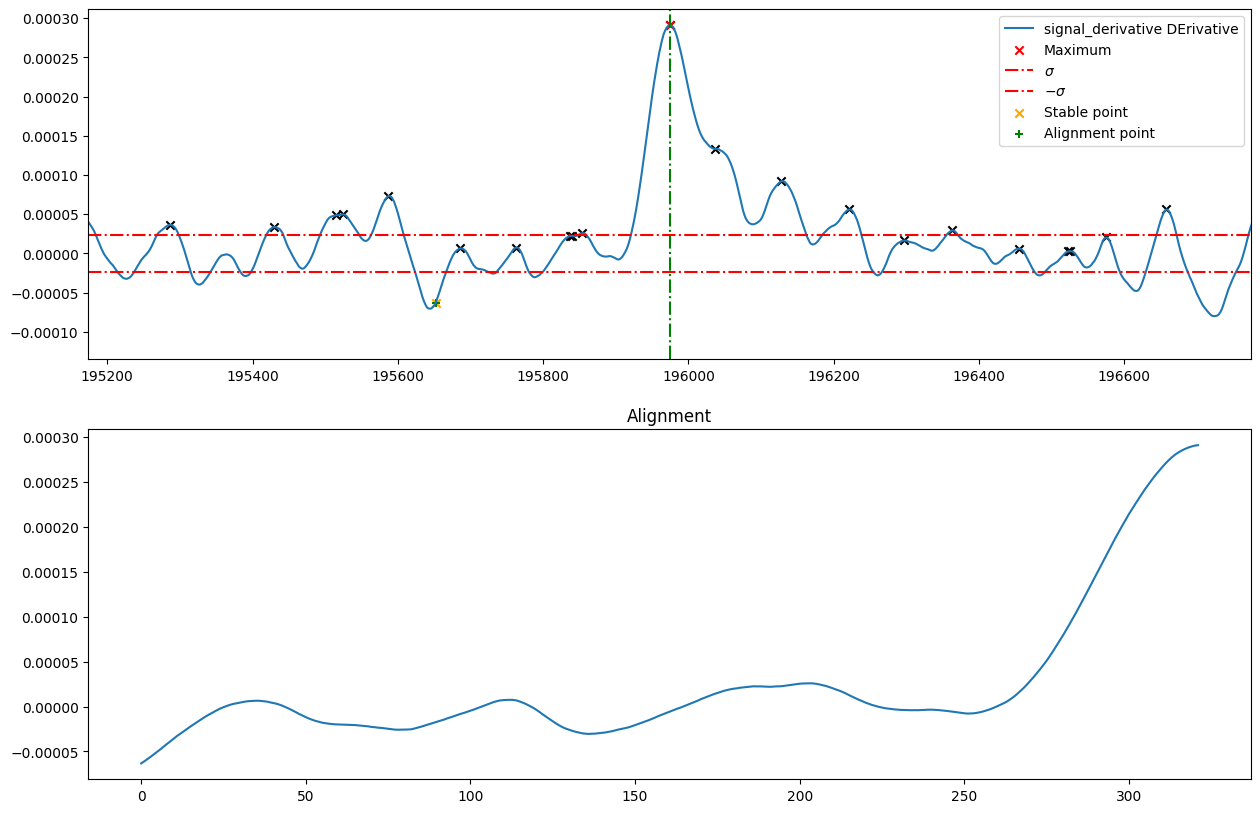

In [27]:
xmin,x_alignment, final = align(signal_derivative,True)